In [131]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D

# - data downloaded from yahoo finance for LITECOIN USD (LTC)

In [132]:
data = yf.download("LTC-USD", start="2021-03-29", end="2022-03-29")

[*********************100%***********************]  1 of 1 completed


# script run to check if the data has been completely uploaded by checking the head and tail

In [133]:
data.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-28,184.824356,187.745636,181.670151,185.028488,185.028488,2162823815
2021-03-29,185.015610,197.488892,183.475006,194.474777,194.474777,3353971422
2021-03-30,194.470825,200.121155,191.152344,196.682098,196.682098,3604665752
2021-03-31,196.688950,199.282684,189.491013,197.499100,197.499100,3416343750
2021-04-01,197.524368,205.466995,195.942993,204.112518,204.112518,3871809467


In [134]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-24,122.468063,127.293190,120.852119,126.581276,126.581276,1007870447
2022-03-25,126.582520,127.094101,122.376961,124.067368,124.067368,822120492
2022-03-26,124.071068,125.360939,122.287392,124.881332,124.881332,560151992
2022-03-27,124.889275,129.397476,123.675545,129.397476,129.397476,740569100
2022-03-28,129.400635,132.412476,127.852745,127.938614,127.938614,943699101


In [135]:
data['Adj Close'].head()

Date
2021-03-28    185.028488
2021-03-29    194.474777
2021-03-30    196.682098
2021-03-31    197.499100
2021-04-01    204.112518
Name: Adj Close, dtype: float64

# - Plot showing movement in prices for one year on continous basis

<AxesSubplot:xlabel='Date'>

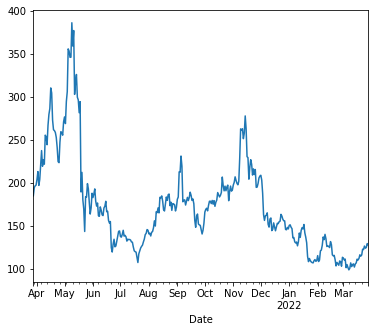

In [136]:
data['Adj Close'].plot(figsize=(6,5)) 

# - Calculating normal returns

In [137]:
normal_return = []
for i in range(0,len(data)-1):
    adjclose_yesterday = data.iloc[i]['Adj Close']
    adjclose_today = data.iloc[i+1]['Adj Close']
    x = (adjclose_today - adjclose_yesterday) / adjclose_yesterday
    normal_return.append(x)
normal_return[:5]

[0.05105316028077457,
 0.01135016683667973,
 0.004153918172862516,
 0.03348581633077991,
 0.044661029708483055]

# - calculating log returns

In [138]:
log_return = []
for i in range(0,len(data)-1):
    adjclose_yesterday = data.iloc[i]['Adj Close']
    adjclose_today = data.iloc[i+1]['Adj Close']
    y = np.log(adjclose_today / adjclose_yesterday)
    log_return.append(y)
log_return[:5]

[0.049792671282424705,
 0.011286236981288491,
 0.004145314472584292,
 0.03293737612754386,
 0.043692459311610914]

# - calculating the annualised volatility

In [139]:
dfnr = pd.DataFrame(normal_return, columns = ['normal']) 
nr = dfnr.mean() * len(dfnr)
nv = dfnr.std() * (len(dfnr) ** 0.5)
print('The annualized normal return is %.8f and its annualized volatility is %.8f' % (nr,nv))

The annualized normal return is 0.24938647 and its annualized volatility is 1.09379666


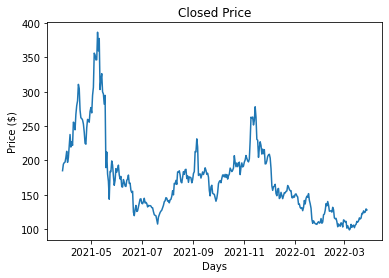

In [140]:
fig = plt.figure()
plt.plot(data['Close'])
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.title('Closed Price');

In [141]:
SP = data['Adj Close'][-1]
print('The spot price is', round(SP,2))

The spot price is 127.94


# - Pricing of Options Using Binomial Trees, Montecalo and Black-Scholes 

# - We first establish the spot price, strike price, maturity time, interest free rate, annualised volatility and steps

In [142]:
import os

In [143]:
S0 = 127.94             # spot price as at March 28, 2022 (the most recent date in the download)
K = 130.0               # strike price (i assumed strike price 130.0 which is close to the spot price)
T = 1.0/52.0            # maturity period of the option (one week have been chosen for the maturity of the option)
r = 0.0162              # U.S.risk free rate (the risk free rate was was 1.62 so divided by 100 gives 0.0162 (bloomberg on 30/03/2022)
sig = 1.0937            # diffusion coefficient or volatility as derived above
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff 

# - Pricing Using Binomial Trees

# - We construct tree for the underlying asset price as follows:

In [144]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u        

In [145]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

# - to check S, we have the below binomal tree (4 by 4 matrix)

In [146]:
S 

array([[127.94      , 139.6483511 , 152.42818481, 166.37755721],
       [  0.        , 117.21329662, 127.94      , 139.6483511 ],
       [  0.        ,   0.        , 107.38593798, 117.21329662],
       [  0.        ,   0.        ,   0.        ,  98.3825215 ]])

# - Next is to set up our risk neutral probability

In [147]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.4787146898343185

In [148]:
q

0.5212853101656816

# - finding the option value at each node

In [149]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 12.78670338],
       [ 0.        ,  0.        ,  0.        , 31.6174785 ]])

# - we then calculate the value the option starting from 2nd to the last step of the tree to the first i.e. valuation date

# - European Option

In [150]:
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 9.46584904,  3.47391641,  0.        ,  0.        ],
       [ 0.        , 14.97033796,  6.66482848,  0.        ],
       [ 0.        ,  0.        , 22.60056272, 12.78670338],
       [ 0.        ,  0.        ,  0.        , 31.6174785 ]])

In [151]:
print('European ' + payoff, str( V[0,0]))

European put 9.465849039272058


# - American Option

In [152]:
if payoff =="call":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(S[i,j] - K,np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
elif payoff =="put":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(K - S[i,j],np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
V

array([[ 9.46951656,  3.47391641,  0.        ,  0.        ],
       [ 0.        , 14.97737421,  6.66482848,  0.        ],
       [ 0.        ,  0.        , 22.61406202, 12.78670338],
       [ 0.        ,  0.        ,  0.        , 31.6174785 ]])

In [153]:
print('American ' + payoff, str( V[0,0]))

American put 9.469516555063597


# - Price of Options using Monte-Carlo Simulation

# We need to set a function before we run the simulation called Montecalo simulation (mcs) p steps as follows:

In [154]:
def mcs_simulation_np(p):
    M = p
    I = p      ## I number of simulation
    dt = T / M ## M number of time step for each simulation
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [155]:
T = 1.0/52.0
r = 0.0162
sigma = 1.09  
S0 = 127.94
K = 130.0

In [156]:
S = mcs_simulation_np(10000)

In [157]:
S = np.transpose(S)
S

array([[127.94      , 128.19169505, 127.84619149, ..., 131.27913025,
        131.52723634, 131.52877842],
       [127.94      , 127.84624271, 127.98370562, ..., 133.98407486,
        133.83753799, 133.94221685],
       [127.94      , 127.74362942, 127.901531  , ..., 118.13590852,
        118.24605918, 118.21571189],
       ...,
       [127.94      , 127.86925741, 127.64553839, ..., 153.92185   ,
        153.34886413, 153.32042478],
       [127.94      , 127.88684081, 127.90752929, ..., 153.59538638,
        153.73260837, 153.72105546],
       [127.94      , 127.77640089, 127.35088471, ..., 122.61256698,
        122.47716721, 122.42345647]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-period values')

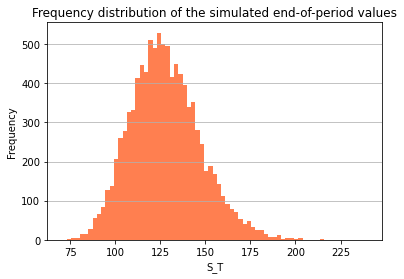

In [158]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#ff7f50',alpha=1, rwidth=2.5)

plt.grid(axis='y', alpha=0.95)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-period values')

# we can then find the value of the option

In [159]:
p = np.mean(np.maximum(K - S[:,-1],0)) * np.exp(-r * T)
print('European put', str(p))

European put 8.833207302338302


In [160]:
c = np.mean(np.maximum(S[:,-1] - K,0)) * np.exp(-r * T)
print('European call', str(c))

European call 6.80823179207374


# - Computing Using Black-Scholes Model

# - we set up a function for the Black-Scholes equation and calculate d1 and d2 as follows

In [161]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [162]:
S= 127.94
K = 130
T = 1.0/52.0
r = 0.0162
vol= 1.09

In [163]:
call = euro_option_bs(S, K, T, r, vol, 'call')
print('The BS call price is', round(call, 2))

The BS call price is 6.8


In [164]:
# put = euro_option_bs(S, K, T, r, vol, 'put')
print('The BS put price is', round(put, 2))

The BS put price is 8.82


# Computation of Greeks

# Delta ((First derivative of the value function)

#  We need to first define the function to find d1 as follows

In [165]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.4 * vol ** 1) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.4 * vol ** 1) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(- q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(- q * T) * si.norm.cdf(- d1, 0.0, 1.0)
    
    return delta

# compute Delta as follows: it was assumed that dividend is zero 

In [166]:
delta(127.94, 130, 1.0/52.0, 0.0162, 0, 1.09, 'call')  

0.48080166899982135

In [ ]:
## if Litecoin price increase by $1, the value of the derivative (option) will increase by $0.480816

In [167]:
delta(127.94, 130, 1.0/52.0, 0.0162, 0, 1.09, 'put') 

-0.5191983310001786

In [ ]:
## if Litecoin USD price increase by $1, the value of the derivative (option) will decrease by $0.519198

In [168]:
S = np.linspace(40, 140, 41)
T = np.linspace(0.5, 2, 41)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 130, T[i], 0.0162, 0.00, 1.09, 'put')

# - Plotting 3D, we have 

C:\Users\W18572~1.INT\AppData\Local\Temp/ipykernel_9380/3050292415.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


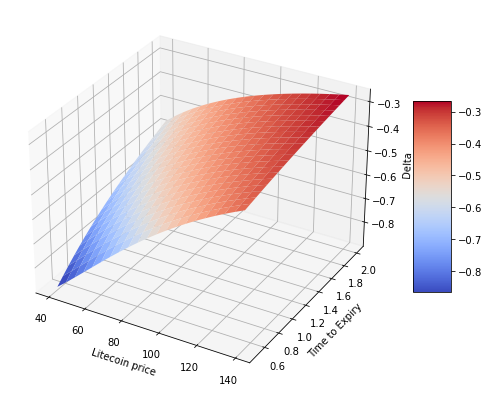

In [169]:
fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Litecoin price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# - Calculation of Gamma (second derivative of the value function) 

In [ ]:
## - We need to first define the function to find d1 as follows

In [170]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 1) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [171]:
gamma(127.94, 130, 1.0/52.0, 0.0162, 0, 1.09, 'call')

0.020610499021442755

In [172]:
gamma(127.94, 130, 1.0/52.0, 0.0162, 0, 1.09, 'put')

0.020610499021442755

In [ ]:
## - Gamma is always the same for both call and put options, the reason the figures for both call and put are the same above

In [ ]:
## - The result means that if Litecoin USD price increase by $1, delta will increase by 0.0206104

In [173]:
S = np.linspace(40, 140, 41)
T = np.linspace(0.5, 2, 41)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 130, T[i], 0.0162, 0.00, 1.09, 'put') 

# - Plotting 3D, we have 

C:\Users\W18572~1.INT\AppData\Local\Temp/ipykernel_9380/1646455710.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


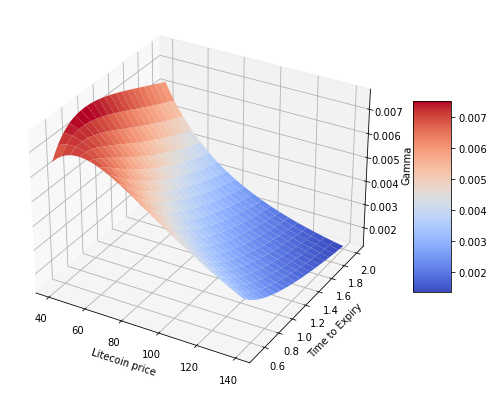

In [174]:
fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Litecoin price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# - Calculation of Speed (third derivative of the value function) 

# - We need to first define the function to find d1 as follows

In [175]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [176]:
speed(127.94, 130, 1.0/52.0, 0.0162, 0, 1.09, 'call') ## -0.0000182058565387638

-1.8205856538763825e-05

In [177]:
speed(127.94, 130, 1.0/52.0, 0.0162, 0, 1.09, 'put') ## -0.0000182058565387638

-1.8205856538763825e-05

In [ ]:
## - Speed is always the same for both call and put options, the reason the figures for both call and put are the same above

In [ ]:
## - The result means that if Litecoin USD price increase by $1, gamma will decrease by 0.000018205

In [178]:
S = np.linspace(40, 140, 41)
T = np.linspace(0.5, 2, 41)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 130, T[i], 0.0162, 0.00, 1.09, 'put')

# - Plotting 3D, we have 

C:\Users\W18572~1.INT\AppData\Local\Temp/ipykernel_9380/1179503517.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


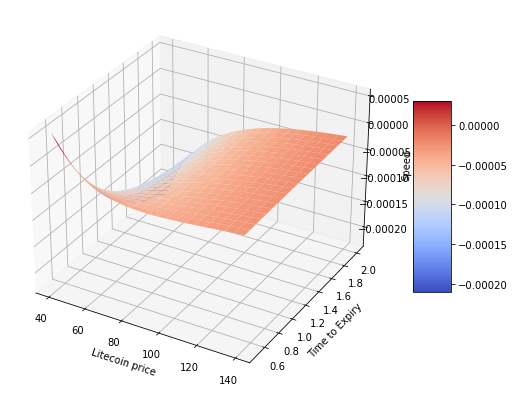

In [179]:
fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Litecoin price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

# - Calculation of Theta 

In [ ]:
## We need to first define the function to find d1 and d2 as follows

In [180]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [181]:
theta(127.94, 130, 1.0/52.0, 0.0162, 0.00, 1.09, 'call')

201.41661527299962

In [182]:
theta(127.94, 130, 1.0/52.0, 0.0162, 0, 1.09, 'put')

201.71601869101454

In [ ]:
## - The longer the time, the more the uncertainty and expensive while less time less uncertainty and cheaper. This means the value of results here should be positive.

In [ ]:
## - This results means if time to maturity for the call option decrease by one day i.e. 1/365 it will lead to decrease of 201.72/365 in the option value

In [183]:
S = np.linspace(40, 140, 41)
T = np.linspace(0.5, 2, 41)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 130, T[i], 0.0162, 0.00, 1.09, 'put')

# - Plotting the 3D, we have

C:\Users\W18572~1.INT\AppData\Local\Temp/ipykernel_9380/2017047480.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


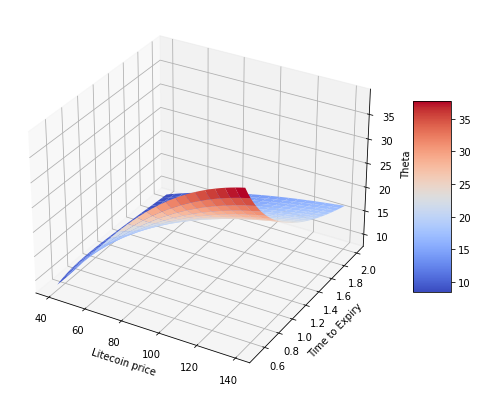

In [184]:
fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Litecoin price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# - Calculation of Rho 

In [ ]:
## We need to first define the function to find d1 and d2 as follows

In [185]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [186]:
rho(127.94, 130, 1.0/52.0, 0.0162, 0.00, 1.09, 'call')

1.071902056134046

In [187]:
rho(127.94, 130, 1.0/52.0, 0.0162, 0.00, 1.09, 'put')

-1.4273192190197768

In [ ]:
## - for call it means 1% increase in the risk free rate would lead to increase of 1%*1.07190205 dollar in the value of the call option; though in real life it cant be 1% change, it will be 0.1% or 0.05%.

In [ ]:
## - for put it means 1% decrease in the risk free rate would lead to increase of 1%*1.427319 dollar in the value of the put option

In [188]:
S = np.linspace(40, 140, 41)
T = np.linspace(0.5, 2, 41)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 130, T[i], 0.0162, 0.00, 1.09, 'put')

# - Plotting the 3D, we have

C:\Users\W18572~1.INT\AppData\Local\Temp/ipykernel_9380/4058554006.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


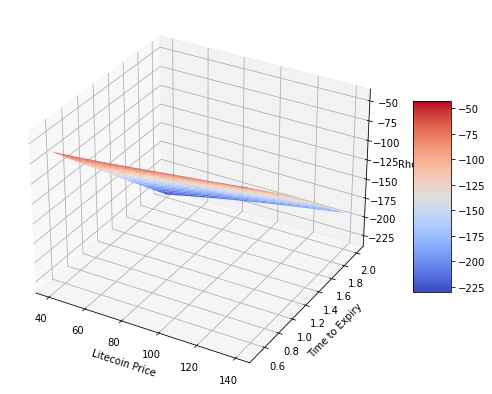

In [189]:
fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Litecoin Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

# - Calculation of Vega 

In [ ]:
## We need to first define the function to find d1 as follows

In [190]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega


In [191]:
vega(127.94, 130, 1.0/52.0, 0.0162, 0.00, 1.09, 'call')

7.075287402290484

In [192]:
vega(127.94, 130, 1.0/52.0, 0.0162, 0.00, 1.09,'put')

7.075287402290484

In [ ]:
## -Results for call and put are always the same

In [ ]:
## - 1% increase in implied volatility whether it is call or put, the value of the option (underlying asset) will increase by 1%*7.07528740 dollar. The change is in dollar

In [193]:
S = np.linspace(40, 140, 41)
T = np.linspace(0.5, 2, 41)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 130, T[i], 0.0162, 0.00, 1.09, 'put')

C:\Users\W18572~1.INT\AppData\Local\Temp/ipykernel_9380/2752134555.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


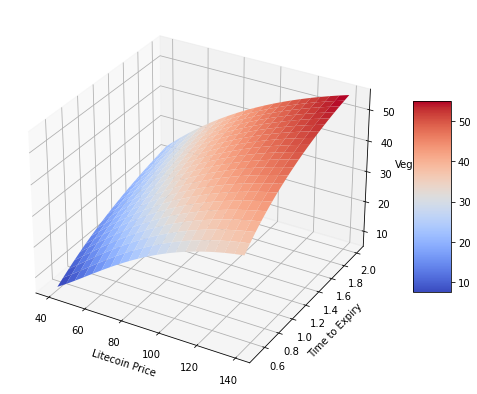

In [194]:
fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Litecoin Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);